# Principle Component Analysis for Classification of prematurity using structural connectivity
The aim is to fit a logistic regression classifier to predict prematurity from neonatal brain connectivity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

(433, 90, 90)


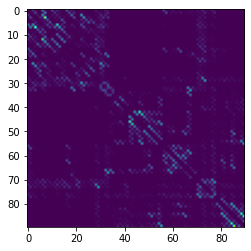

In [2]:
# load connectivity matrices
import pickle
matrices = pickle.load(open("data/matrices.p", "rb"))
print(matrices.shape)  # shape (433, 90, 90)
plt.imshow(matrices[1, :, :])

In [3]:
# convert upper triangles of the matrices to feature vectors

# dimensions
n = matrices.shape[0]
m = matrices.shape[1]
D = round(m*(m-1)/2)
print('n={}, D={}'.format(n,D))

# feature matrix
X=np.zeros([n,D])
for i in range(n):
    index=0
    for j in range(m):
        for k in range(j):
            X[i,index]=matrices[i,j,k]
            index=index+1
print(X.shape)

n=433, D=4005
(433, 4005)


In [4]:
# load subject info
subject_info = pd.read_csv('data/subject_info.csv')
subject_info

,age,prematurity
0,41,0
1,41,0
2,40,0
3,41,0
4,41,0
...,...,...
428,44,0
429,41,0
430,44,0
431,42,0


In [5]:
label_names = pd.read_csv("data/label_names.csv")
label_names

,Label,Region name,Region description
0,1.0,Precentral_L,Precental gyrus
1,2.0,Precentral_R,Precental gyrus
2,3.0,Frontal_Sup_L,"Superior frontal gyrus, dorsolateral"
3,4.0,Frontal_Sup_R,"Superior frontal gyrus, dorsolateral"
4,5.0,Frontal_Sup_Orb_L,"Superior frontal gyrus, orbital part"
...,...,...,...
85,86.0,Temporal_Mid_R,Middle temporal gyrus
86,87.0,Temporal_Pole_Mid_L,Temporal pole: middle temporal gyrus
87,88.0,Temporal_Pole_Mid_R,Temporal pole: middle temporal gyrus
88,89.0,Temporal_Inf_L,Inferior temporal gyrus


## Preprocessing
Prepare prepare your data for training machine learning models:
* Normalise feature matrix `X` using `StandardScaler`
* Extract label vector `y` that represents prematurity

In [6]:
# Your preprocessing
from sklearn.preprocessing import StandardScaler

# Fit and transform at the same time
X = StandardScaler().fit_transform(X)

# Get labels as a pandas Series
y = subject_info["prematurity"]

## Analysis of the dataset
Investigate important characeristics of the dataset:
* print the number of features and samples
* print out the number of all babies, term and preterm babies, and calculate the proportion of preterm babies.

In [ ]:
# print characteristics of the data
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples (all babies): {X.shape[0]}")

print(
    "Term, and preterm babies: \n",
    y.value_counts().rename({0: "Term", 1: "Preterm"}),
    "\n",
)
print(
    "Proportions: \n",
    y.value_counts(normalize=True).rename({0: "Term", 1: "Preterm"}),
)

Visualise the dataset - reduce the feature matrix using PCA. 

In [ ]:
# visualise the dataset using PCA
from sklearn.decomposition import PCA

# first try to find the optimal number of components using the elbow method
pca = PCA().fit(X)
plt.plot(pca.explained_variance_ratio_, marker="o")
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.show()

# the elbow method suggest 3 components
# now I double check the amount of variance explained by 3 components
print("Variance explained by 3 components: ", np.cumsum(pca.explained_variance_ratio_)[:3])

# the first 3 components only explain 20% of the variance, which is not enough
# therefore I will use variance-based selection to find the number of components that explain 95% of the variance
pca = PCA(n_components=0.95).fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.show()

# looking at the graph, it seems that each component explains a small amount of variance
# print the number of components (323)
# therefore the dimensionality reduction will still be very effective (from 4050 to 323)
print("Number of components that explains 95% variance: ", pca.n_components_)

# perform a new PCA with the number of components that explain 95% of the variance
pca = PCA(n_components=pca.n_components_)
X_pca = pca.fit_transform(X)

# plot the data using the first 3 principal components since plotting 323 dimensions is not possible
fig = plt.figure()
fig = fig.add_subplot(projection="3d")
fig.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=y,
    cmap="rainbow",
)
fig.legend(["Term", "Preterm"])
plt.show()

## Evaluation framework
Create the test set for final evaluation of your classifier. Use 20% of the data and stratify the split by the label. Verify that the stratification has worked.

In [ ]:
# Training and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=42)

# to verify the stratification, we can see the labels distribution for both training and testing data (expected to be 80/20):
print("Labels distribution for training data \n")
print(y_train.value_counts(normalize=True).rename({0: "Term", 1: "Preterm"}))

print("Labels distribution for testing data \n")
print(y_test.value_counts(normalize=True).rename({0: "Term", 1: "Preterm"}))

Using PCA transformed features, display training and test set.

In [ ]:
# Visualise Training and Test set
fig = plt.figure()
fig = fig.add_subplot(projection="3d")
fig.scatter(
    X_train[:, 0],
    X_train[:, 1],
    X_train[:, 2],
    c=y_train,
    cmap="rainbow",
)
fig.legend(["Term", "Preterm"])
plt.title("Training Set")
plt.show()

fig = plt.figure()
fig = fig.add_subplot(projection="3d")
fig.scatter(
    X_test[:, 0],
    X_test[:, 1],
    X_test[:, 2],
    c=y_test,
    cmap="rainbow",
)
fig.legend(["Term", "Preterm"])
plt.title("Test Set")
plt.show()

Write function `evaluationTrain(model,X,y)` that will
* fit the model
* print out the accuracy calculated on the training set

In [ ]:
# evaluationTrain
def evaluationTrain(model, X, y):
    model.fit(X, y)
    print(f"Accuracy: {model.score(X, y)}")

Write function `evaluationCV(model,X,y)` that will calculate the following measures using cross-validation:
* Accuracy
* Sensitivity
* Specificity
* Mean Recall

In [ ]:
# evaluationCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

def evaluationCV(model, X, y):
    # Accuracy
    accuracy = cross_val_score(model, X, y, cv=5)
    print(f"Mean Accuracy: {accuracy.mean().round(4)}")

    # Sensitivity
    sensitivity = cross_val_score(model, X, y, cv=5, scoring="recall")
    print(f"Mean Sensitivity: {sensitivity.mean().round(4)}")

    # Specificity
    specificity = cross_val_score(model, X, y, cv=5, scoring=make_scorer(recall_score, pos_label=0))
    print(f"Mean Specificity: {specificity.mean().round(4)}")

    # Mean Recall
    recall = cross_val_score(model, X, y, cv=5, scoring="recall_macro")
    print(f"Mean Recall: {recall.mean().round(4)}")

    # break
    print("--------------------------")

Write function `evaluationTest(model,X,y)` that will calculate the following measures on test set:
* Accuracy
* Sensitivity
* Specificity
* Mean Recall

In [ ]:
# evaluationTest
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, precision_score, recall_score

def evaluationTest(model, X, y):
    # Accuracy
    accuracy = accuracy_score(y, model.predict(X))
    print(f"Accuracy: {accuracy}")

    # Sensitivity
    sensitivity = recall_score(y, model.predict(X), pos_label=1)
    # tn, fp, fn, tp = confusion_matrix(y, model.predict(X)).ravel()
    # sensitivity_matrix = tp / (tp + fn)

    print(f"Sensitivity: {sensitivity}")

    # Specificity
    specificity = recall_score(y, model.predict(X), pos_label=0)
    # tn, fp, fn, tp = confusion_matrix(y, model.predict(X)).ravel()
    # specificity_matrix = tn / (tn+fp)
    print(f"Specificity: {specificity}")

    # Mean Recall
    recall = recall_score(y, model.predict(X), average="macro")
    print(f"Mean Recall: {recall}")

    # Confusion Matrix (for the test set)
    print(f"Confusion Matrix: \n {confusion_matrix(y, model.predict(X))}")

    # break
    print("--------------------------")

## Train a classifier
Select a standard logistic regression classifier. Train and tune it using the correct set of data. Print out the tuned parameters and the best cross-validated score.

In [ ]:
# Fit logistic regression classifier
# and tune hypterparameters using GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# remove convergence and user warnings caused by penalty not compatible with some solvers
import warnings
warnings.filterwarnings("ignore")


# Create logistic regression
classifier = LogisticRegression()
grid = {
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "C": np.logspace(-3, 1, 50),
}
# define grid search
cv = GridSearchCV(estimator=classifier, param_grid=grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=10)
cv.fit(X_train, y_train)

# summarize results
print(f"Best cross-validation score: {cv.best_score_.round(4)}")
print(f"Best parameters: {cv.best_params_}")

classifier = LogisticRegression(**cv.best_params_)
evaluationTrain(classifier, X_train, y_train)


Evaluate the fitted model on the whole training set and using cross-validataion.

In [ ]:
# evaluate
evaluationCV(classifier, X_train, y_train)

Interpret the performance results:
The model has a high accuracy and specificity, but a low sensitivity. This means that the model is good at predicting term births, but not preterm births. This is likely due to the class imbalance in the dataset.



Design a solution to address the problem with the classifier performance that you identified.

In [ ]:
# Updated classifier
# use class_weight="balanced" to address the problem with the classifier performance
classifier_updated = LogisticRegression(**cv.best_params_, class_weight="balanced")
classifier_updated.fit(X_train, y_train)

Evaluate performance of updated model on the whole training set and using cross-validation. 

In [ ]:
# evaluate
evaluationCV(classifier_updated, X_train, y_train)

The dataset is unbalanced with 20% of samples consisting of premature infants, indicating a bias toward predicting term births. I use the 'class weight' parameter to assign preterm babies more weight. The performance was improved with sensitivity increasing from ~0.64 to ~0.7, that model is now better at predicting preterms.

# Some Challenges
* **Challenge 1:** The dataset is unbalanced, as only 20% of the samples are premature infants. To address this issue, I use the 'class weight' parameter of the logistic regression classifier to give preterm babies more weight.
* **Challenge 2:** The dataset only contains 433 samples. To address this issue, I evaluate the model using cross-validation.

## Results
Evaluate performance of both classifiers on the test set.

In [ ]:
# evaluate classifier 1
evaluationTest(classifier, X_test, y_test)

In [ ]:
# evaluate classifier 2
evaluationTest(classifier_updated, X_test, y_test)

The conclusions has not changed. The updated model is still better at predicting preterm births with a slightly higher accuracy. Plus, the accuracy on the test set is about the same and sometimes slightly higher than the cross-validated accuracy on train set, indicating that the model is not over- nor under-fitting.

Visualise the results using PCA. To do that, plot the data with their true labels in one plot and the predicted labels in the other. Do that for both training set and test set. Select the best performing classifier to do that.

In [ ]:
# plot 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=y_test, cmap="viridis")
ax.set_title("True labels")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=classifier_updated.predict(X_test), cmap="viridis")
ax.set_title("Predicted labels")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()